## Photon distinguishability

### What is photon distinguishability?

Ideal photonic quantum computing assumes that the photons are not distinguishable -- that we do not know what the internal quantum states of photons are (or equivalently that the internal states are the same). In practice, this assumption is not met. Any imperfections in hardware will cause the internal states of photons to differ.

 Photon indistinguishability is crucial because nearly all photonic quantum-processing schemes rely on multi-photon interference (for example, the famous Hong–Ou–Mandel effect). When two or more photons arrive at a beamsplitter in indistinguishable states (same frequency, bandwidth, polarization, spatial mode, and arrival time), they can “bunch” together (i.e., exit in the same mode) with high probability due to quantum interference. This is the basis for many gate implementations, such as controlled-NOT gates and other linear optical circuits used in boson sampling or other quantum protocols.

 Graphically, we can represent (and compute the effect of) the Hong-Ou-Mandel effect as follows:

 ![HOM](./hom.png "Hong-Ou-Mandel Effect")

#### How is photon distinguishability implemented in Optyx?

In optyx, we can treat each bosonic wire as encoding a probability amplitude of an internal state of a photon. If we create a photon, we can use the white triangle and the endomorphisms on each outpu wire to achieve that:

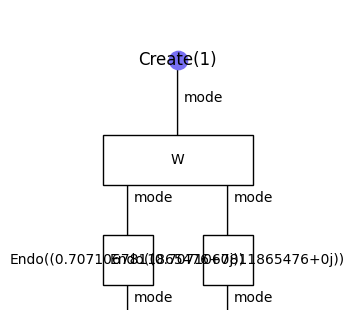

In [1]:
from optyx.zw import W, Create, Endo

internal_state = [0.5**0.5, 0.5**0.5]
photon_internal_state = (
    Create(1) >>
    W(2) >>
    Endo(internal_state[0]) @ Endo(internal_state[1])
)

photon_internal_state.foliation().draw()

In [2]:
photon_internal_state.to_tensor().eval().array

array([[0.        +0.j, 0.70710678+0.j],
       [0.70710678+0.j, 0.        +0.j]])

In dual rail encoding this is a $|+\rangle$ state:

In [3]:
from optyx.optyx import DualRail

(
    photon_internal_state >> DualRail().dagger()
).to_tensor().eval().array

array([0.70710678+0.j, 0.70710678+0.j])

In Optyx, we do not need to define this inflation of wires manually. As we discuss below, we can define a diagram and internal states that we create and let Optyx handle the mapping into the distinguishable setting.

### Non-distinguishable photons

We will show that if the photons are non-distinguishable, we obtain a perfect Hong-Ou-Mandel effect.

In [4]:
from optyx.channel import Channel
from optyx.lo import BS
from optyx.channel import qmode, Measure

The states of two particles are the same:

In [46]:
internal_state_1 = [0.5**0.5, 0.5**0.5]
internal_state_2 = [0.5**0.5, 0.5**0.5]

In [47]:
channel_BS = (Channel(
    "BS",
        (
            Create(1, 1, internal_states=(internal_state_1,
                                          internal_state_2)) >>
            BS
        )
    ) >> Measure(qmode**2)
).inflate(len(internal_state_1))

In [48]:
result = channel_BS.double().to_zw().to_tensor(max_dim=3).eval().array

In [49]:
import numpy as np

rounded_result = np.round(result, 3)

non_zero_dict = {idx: val for idx, val in np.ndenumerate(rounded_result) if val != 0}
print(non_zero_dict)

{(0, 2): (0.5+0j), (2, 0): (0.5+0j)}


This means that we cannot get a single photon at each output.

### Distinguishable photons

Here, we define states which are different:

In [188]:
internal_state_1 = np.random.rand(2) + 1j*np.random.rand(2)
internal_state_1 = internal_state_1 / np.linalg.norm(internal_state_1)
internal_state_2 = np.random.rand(2) + 1j*np.random.rand(2)
internal_state_2 = internal_state_2 / np.linalg.norm(internal_state_2)

In [189]:
internal_state_1

array([0.61893411+0.69484199j, 0.14888627+0.3345864j ])

In [190]:
internal_state_2

array([0.43693508+0.68426881j, 0.58355278+0.0181682j ])

In [193]:
channel_BS = (Channel(
    "BS",
        (
            Create(1, 1, internal_states=(internal_state_1,
                                          internal_state_2)) >>
            BS
        )
    ) >> Measure(qmode**2)
).inflate(2)

In [194]:
result = channel_BS.double().to_zw().to_tensor(max_dim=3).eval().array

In [195]:
import numpy as np

rounded_result = np.round(result, 6)

non_zero_dict = {idx: val for idx, val in np.ndenumerate(rounded_result) if val != 0}
print(non_zero_dict)

{(0, 2): (0.427238-0j), (1, 1): (0.145524-0j), (2, 0): (0.427238-0j)}


We obtain a single photon at each output with 1/4 probability. This can be confirmed using the formula: $\frac{1}{2} - \frac{1}{2} \left| \langle \psi_0 | \psi_1 \rangle \right|^2$

In [196]:
0.5 - 0.5*np.abs(np.array(internal_state_1).dot(np.array(internal_state_2).conjugate()))**2

0.14552415412033015